<a href="https://colab.research.google.com/github/Rotichkiprono/XrayAndCTscan/blob/main/Covid19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np  # For numerical operations
import matplotlib.pyplot as plt  # For data visualization
import os  # For handling file paths and directories
import cv2  # For image preprocessing
import tensorflow as tf  # Core library for building ML models
from tensorflow import keras  # High-level neural network API
from keras.callbacks import EarlyStopping, ModelCheckpoint  # For controlling training
from sklearn.metrics import (  # For model evaluation
    confusion_matrix, accuracy_score, classification_report)
from sklearn.model_selection import train_test_split  # For splitting the dataset
from sklearn.preprocessing import LabelEncoder  # For encoding labels (if needed)
from tqdm import tqdm  # For showing progress bars during data preprocessing
import warnings  # For handling warnings

# Suppress warnings for cleaner output during development
warnings.filterwarnings('ignore')

In [3]:
import os
import glob
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm import tqdm

# Define the path to the dataset
image_data = Path('/content/drive/MyDrive/BACKUPS/Datasets/FinalProject/Covid19')

# Get a list of all image file paths in the dataset
image_files = list(image_data.glob('**/*.*'))  # Get all image files in subdirectories
np.random.shuffle(image_files)  # Shuffle the file paths

# Extract labels for binary classification (e.g., "Pneumonia" vs. "Normal")
labels = [
    "Covid19" if "COVID19" in str(path.parent.name) else "Normal"
    for path in image_files
]

# Create a pandas DataFrame for easy handling
df = pd.DataFrame({"Image": image_files, "Label": labels})

# Verify that the DataFrame contains the correct binary labels
print(df["Label"].value_counts())  # Check label distribution
print(df.head())  # Display the first few rows of the DataFrame for verification

Label
Normal     1593
Covid19     576
Name: count, dtype: int64
                                               Image   Label
0  /content/drive/MyDrive/BACKUPS/Datasets/FinalP...  Normal
1  /content/drive/MyDrive/BACKUPS/Datasets/FinalP...  Normal
2  /content/drive/MyDrive/BACKUPS/Datasets/FinalP...  Normal
3  /content/drive/MyDrive/BACKUPS/Datasets/FinalP...  Normal
4  /content/drive/MyDrive/BACKUPS/Datasets/FinalP...  Normal


In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

# Function to visualize label distribution
def plot_label_distribution(
    dataframe,
    label_column="Label",
    title="Label Distribution with Percentages",
    palette_name="pastel"
):
    """Visualize the distribution of binary labels with counts and percentages."""
    try:
        # Set a theme for better aesthetics
        sns.set_theme(style="whitegrid")

        # Calculate counts and percentages for each label
        label_counts = dataframe[label_column].value_counts()
        label_percentages = (label_counts / label_counts.sum() * 100).round(2)

        # Print label percentages (optional for debugging/verification)
        print("Label Percentages:\n", label_percentages)

        # Sort the labels by count in descending order
        sorted_labels = label_counts.index

        # Create a color palette for the bars
        palette = sns.color_palette(palette_name, len(sorted_labels))

        # Plot the count plot
        plt.figure(figsize=(8, 5))  # Adjusted for binary classification
        ax = sns.countplot(
            x=label_column,
            data=dataframe,
            order=sorted_labels,
            palette=palette
        )

        # Annotate each bar with the percentage value
        for bar in ax.patches:
            height = bar.get_height()  # Get the height of the bar
            percentage = f'{(height / label_counts.sum()) * 100:.2f}%'
            ax.annotate(
                percentage,
                (bar.get_x() + bar.get_width() / 2., height),
                ha='center', va='bottom',
                fontsize=10, color='black',
                xytext=(0, 5), textcoords='offset points'
            )

        # Customize the plot
        plt.title(title, fontsize=14, pad=15)
        plt.xlabel("Labels", fontsize=12, labelpad=8)
        plt.ylabel("Count", fontsize=12, labelpad=8)
        plt.xticks(rotation=0, ha='center', fontsize=10)
        sns.despine()

        # Display the plot
        plt.tight_layout()
        plt.show()

    except KeyError as e:
        print(f"Error: The label column '{label_column}' is not present in the DataFrame.")
    except Exception as e:
        print(f"An error occurred: {e}")

Label Percentages:
 Label
Normal     73.44
Covid19    26.56
Name: count, dtype: float64


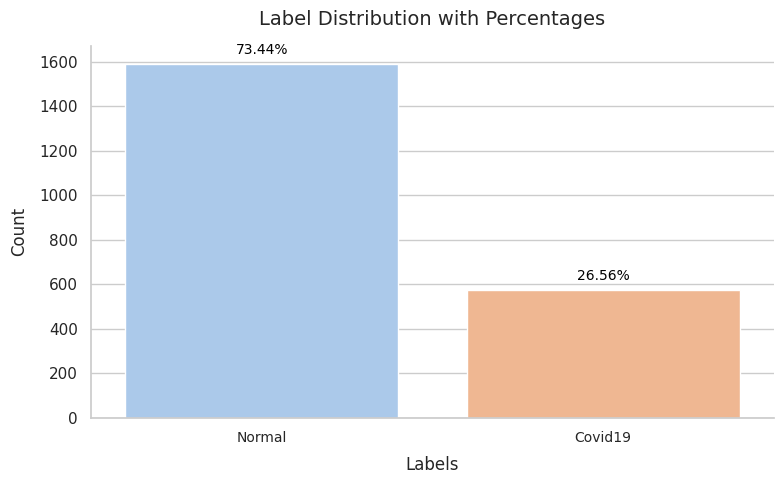

In [5]:
# Assuming `df` is your DataFrame containing the binary labels
plot_label_distribution(df, label_column="Label")

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Parameters for binary classification
train_data_dir = image_data  # Path to the dataset directory
batch_size = 8  # Optimal batch size for small datasets and binary classification
target_size = (224, 224)  # Resize images to match the model's input dimensions
validation_split = 0.25  # Split the dataset into training (75%) and validation (25%)
seed = 100  # Seed for reproducibility

# Data augmentation and preprocessing for training
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,  # Normalize pixel values to [0, 1]
    rotation_range=20,  # Augmentation: random rotation
    width_shift_range=0.2,  # Augmentation: horizontal shifts
    height_shift_range=0.2,  # Augmentation: vertical shifts
    shear_range=0.2,  # Augmentation: shearing transformations
    zoom_range=0.2,  # Augmentation: random zoom
    horizontal_flip=True,  # Augmentation: horizontal flipping
    validation_split=validation_split  # Split dataset into training and validation
)

# Data preprocessing for validation
validation_datagen = ImageDataGenerator(
    rescale=1.0 / 255,  # Normalize pixel values to [0, 1]
    validation_split=validation_split  # Match validation split with training
)

# Create the training dataset generator
train_generator = train_datagen.flow_from_directory(
    directory=train_data_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode="binary",  # Binary classification
    subset="training",  # Training subset
    seed=seed
)

# Create the validation dataset generator
validation_generator = validation_datagen.flow_from_directory(
    directory=train_data_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode="binary",  # Binary classification
    subset="validation",  # Validation subset
    seed=seed
)

Found 1627 images belonging to 2 classes.
Found 542 images belonging to 2 classes.


In [7]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout

base_model = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# Freeze base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers
x = Flatten()(base_model.output)
x = Dense(128, activation="relu")(x)
x = Dropout(0.5)(x)
output = Dense(1, activation="sigmoid")(x)  # Sigmoid activation for binary classification

model = Model(inputs=base_model.input, outputs=output)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [8]:
model.compile(
    optimizer="adam",
    loss="binary_crossentropy",  # Binary cross-entropy loss
    metrics=["accuracy"]
)

In [9]:
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=5,  # Adjust epochs as needed
    steps_per_epoch=len(train_generator),
    validation_steps=len(validation_generator),
    verbose=1
)

Epoch 1/5
204/204 ━━━━━━━━━━━━━━━━━━━━ 1770s 8s/step - accuracy: 0.8450 - loss: 0.5020 - val_accuracy: 0.9576 - val_loss: 0.1197
Epoch 2/5
204/204 ━━━━━━━━━━━━━━━━━━━━ 12s 59ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 3/5
204/204 ━━━━━━━━━━━━━━━━━━━━ 77s 366ms/step - accuracy: 0.9555 - loss: 0.1170 - val_accuracy: 0.9557 - val_loss: 0.1081
Epoch 4/5
204/204 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 5/5
204/204 ━━━━━━━━━━━━━━━━━━━━ 76s 360ms/step - accuracy: 0.9591 - loss: 0.1163 - val_accuracy: 0.9760 - val_loss: 0.0546


In [10]:
val_loss, val_accuracy = model.evaluate(validation_generator)
print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

68/68 ━━━━━━━━━━━━━━━━━━━━ 13s 187ms/step - accuracy: 0.9609 - loss: 0.0760
Validation Loss: 0.0546, Validation Accuracy: 0.9760


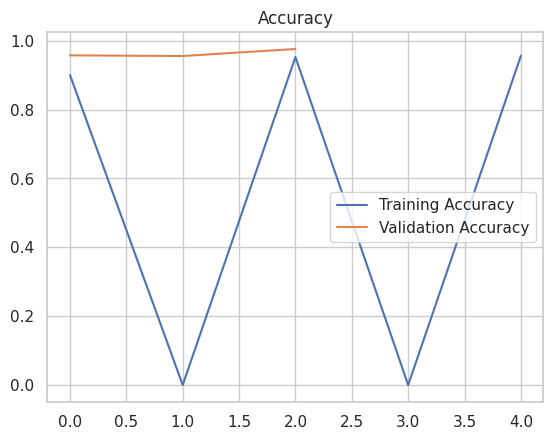

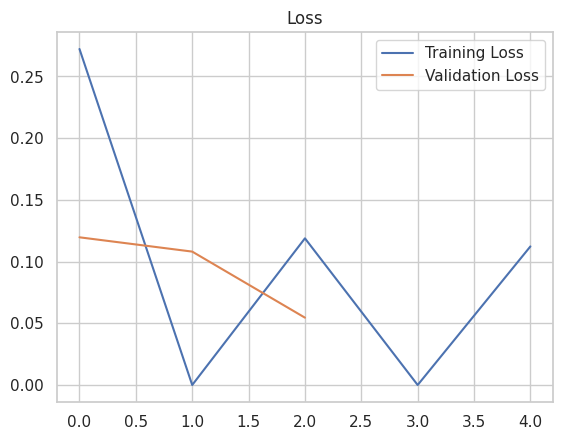

In [11]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.legend()
plt.title("Accuracy")
plt.show()

# Plot loss
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.title("Loss")
plt.show()

In [13]:
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def predict_image(image_path):
    # Load and preprocess the image
    img = load_img(image_path, target_size=(224, 224))
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Make a prediction
    prediction = model.predict(img_array)
    return "Positive" if prediction[0][0] > 0.5 else "Negative"

print(predict_image("/content/download.jpeg"))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Positive


In [14]:
model.export("/content/drive/MyDrive/BACKUPS/Datasets/FinalProject/Covid19/Covid19_model")

Saved artifact at '/content/drive/MyDrive/BACKUPS/Datasets/FinalProject/Covid19/Covid19_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  135763085022608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135763084218032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135763084225072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135763084221904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135763084229120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135763084225424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135763084228064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135763084228944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135763084226832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135763084301888: TensorSpe